In [1]:
# 导入其他需要的库
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
import random
import pickle
import glob
from tqdm import tqdm
import os
# 导入语音处理相关的库
from python_speech_features import mfcc
import scipy.io.wavfile as wav
import librosa
from IPython.display import Audio
# 导入所需的模块和类
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Activation, Lambda, Add, Multiply, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.backend import ctc_batch_cost
from tensorflow.keras.utils import to_categorical, plot_model

In [2]:
# 使用glob匹配所有以.trn为扩展名的文件路径
text_paths = glob.glob('data/*.trn')

# 获取匹配到的文件总数
total = len(text_paths)

# 打印总文件数
print(total)


# 使用with语句打开第一个匹配到的文件
with open(text_paths[0], 'r', encoding='utf8') as fr:
    # 读取文件中的所有行并存储在lines列表中
    lines = fr.readlines()
    
    # 打印读取的行
    print(lines)

13388
['绿 是 阳春 烟 景 大块 文章 的 底色 四月 的 林 峦 更是 绿 得 鲜活 秀媚 诗意 盎然\n', 'lv4 shi4 yang2 chun1 yan1 jing3 da4 kuai4 wen2 zhang1 de5 di3 se4 si4 yue4 de5 lin2 luan2 geng4 shi4 lv4 de5 xian1 huo2 xiu4 mei4 shi1 yi4 ang4 ran2\n', 'l v4 sh ix4 ii iang2 ch un1 ii ian1 j ing3 d a4 k uai4 uu un2 zh ang1 d e5 d i3 s e4 s iy4 vv ve4 d e5 l in2 l uan2 g eng4 sh ix4 l v4 d e5 x ian1 h uo2 x iu4 m ei4 sh ix1 ii i4 aa ang4 r an2\n']


In [3]:
# 初始化空列表，用于存储处理后的文本和文件路径
texts = []
paths = []

# 遍历匹配到的文件路径
for path in text_paths:
    # 使用with语句打开文件
    with open(path, 'r', encoding='utf8') as fr:
        # 读取文件中的所有行并存储在lines列表中
        lines = fr.readlines()
        
        # 提取第一行文本并进行处理，去除换行符和空格
        line = lines[0].strip('\n').replace(' ', '')
        
        # 将处理后的文本添加到texts列表中
        texts.append(line)
        
        # 将处理后的文件路径添加到paths列表中，去除文件扩展名
        paths.append(path.rstrip('.trn'))

# 打印第一个文件路径和对应的文本内容
print(paths[0], texts[0])

data\A11_0.wav 绿是阳春烟景大块文章的底色四月的林峦更是绿得鲜活秀媚诗意盎然


Audio Text: 绿是阳春烟景大块文章的底色四月的林峦更是绿得鲜活秀媚诗意盎然


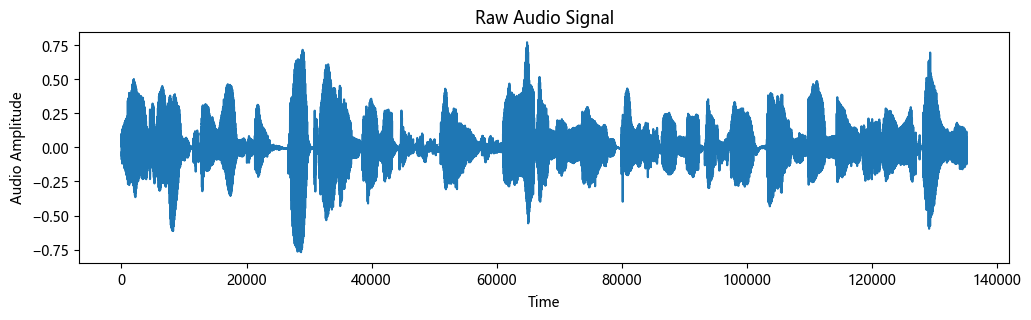

Shape of MFCC: (611, 13)
611


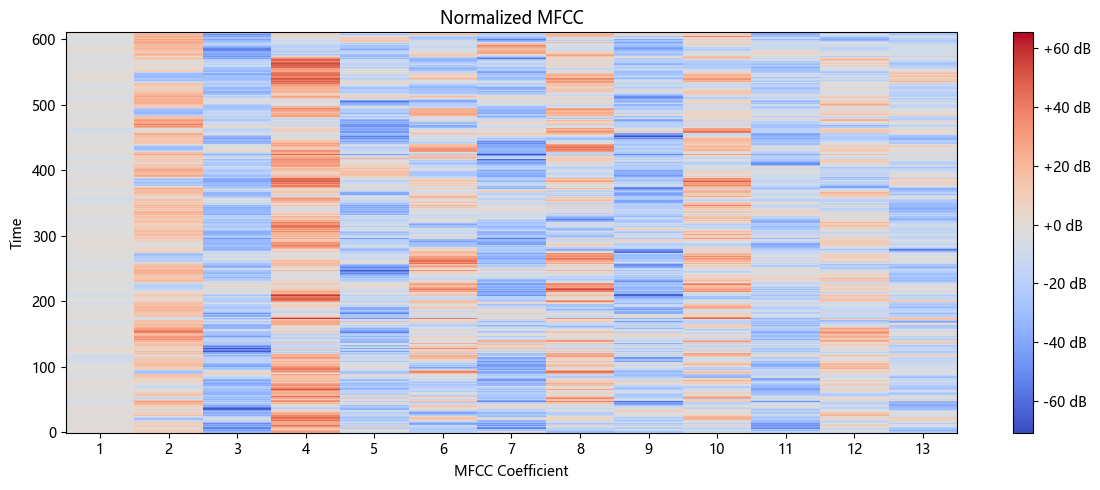

In [98]:
mfcc_dim = 13

def load_and_trim(path):
    audio, sr = librosa.load(path)
    energy = librosa.feature.rms(y=audio)
    frames = np.nonzero(energy >= np.max(energy) / 5)
    indices = librosa.core.frames_to_samples(frames)[1]
    audio = audio[indices[0]:indices[-1]] if indices.size else audio[0:0]
    
    return audio, sr

def visualize(index):
    path = paths[index]
    text = texts[index]
    print('Audio Text:', text)
    
    audio, sr = load_and_trim(path)
    plt.figure(figsize=(12, 3))
    plt.plot(np.arange(len(audio)), audio)
    plt.title('Raw Audio Signal')
    plt.xlabel('Time')
    plt.ylabel('Audio Amplitude')
    plt.show()
    
    feature = mfcc(audio, sr, numcep=mfcc_dim, nfft=551)
    print('Shape of MFCC:', feature.shape)
    
    # Plot MFCC spectrogram with coordinates
    plt.figure(figsize=(12, 5))
    librosa.display.specshow(feature, sr=sr)

    plt.title('Normalized MFCC')
    plt.ylabel('Time')
    plt.xlabel('MFCC Coefficient')
    plt.colorbar(format='%+2.0f dB')
    # Manually set x-axis tick labels for MFCC coefficients
    num_coefficients = feature.shape[0]
    plt.xticks(np.arange(0, 13), np.arange(1, 13 + 1))

    # Manually set y-axis tick labels for time
    num_frames = feature.shape[0]
    print(num_frames)
    time_in_seconds = librosa.frames_to_time(np.arange(0, num_frames, 100), sr=sr)
    time_labels = [t for t in time_in_seconds]
    plt.yticks(np.arange(0, num_frames, 100))

    plt.tight_layout()
    plt.show()
    
#     fig = plt.figure(figsize=(12, 5))
#     ax = fig.add_subplot(111)
#     im = ax.imshow(feature, cmap=plt.cm.jet, aspect='auto')
#     plt.title('Normalized MFCC')
#     plt.ylabel('Time')
#     plt.xlabel('MFCC Coefficient')
#     plt.colorbar(im, cax=make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05))
#     ax.set_xticks(np.arange(0, 13, 2), minor=False);
#     plt.show()
    
    return path

Audio(visualize(0))

In [5]:
features = []

# 使用tqdm来显示循环进度
for i in tqdm(range(total)):
    # 获取当前索引的音频文件路径
    path = paths[i]
    
    # 加载和修剪音频
    audio, sr = load_and_trim(path)
    
    # 计算音频的MFCC特征并添加到features列表中
    features.append(mfcc(audio, sr, numcep=mfcc_dim, nfft=551))
    
# 打印MFCC特征的数量和第一个特征的形状
print(len(features), features[0].shape)

100%|████████████████████████████████████████████████████████████████████████████| 13388/13388 [05:21<00:00, 41.61it/s]

13388 (611, 13)


In [6]:
# 从特征列表中随机抽取100个样本
samples = random.sample(features, 100)

# 将样本堆叠成矩阵
samples = np.vstack(samples)

# 计算抽样样本的MFCC均值和标准差
mfcc_mean = np.mean(samples, axis=0)
mfcc_std = np.std(samples, axis=0)
print(mfcc_mean)
print(mfcc_std)

# 对所有特征进行标准化
features = [(feature - mfcc_mean) / (mfcc_std + 1e-14) for feature in features]

[ -4.14967327   4.11669792 -26.48354921  15.26997423 -22.01156148
  -0.75026929 -17.65198877   8.24770835 -19.84513909   6.81330971
 -12.20458869   0.23630065  -3.10789497]
[ 2.9114123  14.62603648 14.39607397 19.56137074 16.23234723 21.98595788
 18.01476399 17.09312928 15.78298126 15.26114454 13.54093253 12.55481267
 10.71789517]


In [7]:
chars = {}

# 统计所有文本中的字符出现频次
for text in texts:
    for c in text:
        chars[c] = chars.get(c, 0) + 1

# 按字符出现频次排序
chars = sorted(chars.items(), key=lambda x: x[1], reverse=True)

# 仅保留字符列表
chars = [char[0] for char in chars]

# 打印字符数量和前100个字符
print(len(chars), chars[:100])

# 创建字符到ID的映射和ID到字符的映射
char2id = {c: i for i, c in enumerate(chars)}
id2char = {i: c for i, c in enumerate(chars)}

2883 ['的', '一', '有', '人', '了', '不', '为', '在', '是', '十', '用', '我', '外', '要', '也', '而', '中', '上', '二', '国', '他', '大', '和', '文', '来', '年', '子', '这', '到', '业', '生', '越', '于', '下', '地', '个', '以', '着', '家', '时', '月', '区', '出', '后', '成', '与', '五', '日', '能', '们', '多', '又', '可', '学', '王', '员', '三', '天', '行', '山', '发', '长', '运', '等', '因', '百', '同', '儿', '四', '得', '开', '里', '说', '就', '小', '会', '过', '作', '从', '去', '军', '之', '被', '种', '内', '应', '对', '样', '全', '厂', '民', '往', '然', '育', '所', '高', '方', '将', '明', '新']


In [8]:
data_index = np.arange(total)
np.random.shuffle(data_index)
train_size = int(0.9 * total)
test_size = total - train_size
train_index = data_index[:train_size]
test_index = data_index[train_size:]

X_train = [features[i] for i in train_index]
Y_train = [texts[i] for i in train_index]
X_test = [features[i] for i in test_index]
Y_test = [texts[i] for i in test_index]

batch_size = 8


def batch_generator(x, y, batch_size=batch_size):
    offset = 0
    while True:
        offset += batch_size

        if offset == batch_size or offset >= len(x):
            data_index = np.arange(len(x))
            np.random.shuffle(data_index)
            x = [x[i] for i in data_index]
            y = [y[i] for i in data_index]
            offset = batch_size

        X_data = x[offset - batch_size: offset]
        Y_data = y[offset - batch_size: offset]

        X_maxlen = max([X_data[i].shape[0] for i in range(batch_size)])
        Y_maxlen = max([len(Y_data[i]) for i in range(batch_size)])

        X_batch = np.zeros([batch_size, X_maxlen, mfcc_dim])
        Y_batch = np.ones([batch_size, Y_maxlen]) * len(char2id)
        X_length = np.zeros([batch_size, 1], dtype='int32')
        Y_length = np.zeros([batch_size, 1], dtype='int32')

        for i in range(batch_size):
            X_length[i, 0] = X_data[i].shape[0]
            X_batch[i, :X_length[i, 0], :] = X_data[i]

            Y_length[i, 0] = len(Y_data[i])
            Y_batch[i, :Y_length[i, 0]] = [char2id[c] for c in Y_data[i]]

        inputs = {'X': X_batch, 'Y': Y_batch, 'X_length': X_length, 'Y_length': Y_length}
        outputs = {'ctc': np.zeros([batch_size])}

        yield (inputs, outputs)

### 1 不折叠重复模块部分定义模型代码
> 下面还会提供一种使用自定义模块类折叠重复模块部分的代码，可任选一种。

In [9]:
epochs = 50
num_blocks = 3
filters = 128

X = Input(shape=(None, mfcc_dim,), dtype='float32', name='X')
Y = Input(shape=(None,), dtype='float32', name='Y')
X_length = Input(shape=(1,), dtype='int32', name='X_length')
Y_length = Input(shape=(1,), dtype='int32', name='Y_length')


def conv1d(inputs, filters, kernel_size, dilation_rate):
    return Conv1D(filters=filters, kernel_size=kernel_size, strides=1, padding='causal', activation=None,
                  dilation_rate=dilation_rate)(inputs)


def batchnorm(inputs):
    return BatchNormalization()(inputs)


def activation(inputs, activation):
    return Activation(activation)(inputs)


def res_block(inputs, filters, kernel_size, dilation_rate):
    hf = activation(batchnorm(conv1d(inputs, filters, kernel_size, dilation_rate)), 'tanh')
    hg = activation(batchnorm(conv1d(inputs, filters, kernel_size, dilation_rate)), 'sigmoid')
    h0 = Multiply()([hf, hg])

    ha = activation(batchnorm(conv1d(h0, filters, 1, 1)), 'tanh')
    hs = activation(batchnorm(conv1d(h0, filters, 1, 1)), 'tanh')

    return Add()([ha, inputs]), hs


h0 = activation(batchnorm(conv1d(X, filters, 1, 1)), 'tanh')
shortcut = []
for i in range(num_blocks):
    for r in [1, 2, 4, 8, 16]:
        h0, s = res_block(h0, filters, 7, r)
        shortcut.append(s)

h1 = activation(Add()(shortcut), 'relu')
h1 = activation(batchnorm(conv1d(h1, filters, 1, 1)), 'relu')
Y_pred = activation(batchnorm(conv1d(h1, len(char2id) + 1, 1, 1)), 'softmax')
sub_model = Model(inputs=X, outputs=Y_pred)


def calc_ctc_loss(args):
    y, yp, ypl, yl = args
    return ctc_batch_cost(y, yp, ypl, yl)


ctc_loss = Lambda(calc_ctc_loss, output_shape=(1,), name='ctc')([Y, Y_pred, X_length, Y_length])
model = Model(inputs=[X, Y, X_length, Y_length], outputs=ctc_loss)
optimizer = SGD(learning_rate=0.02, momentum=0.9, nesterov=True, clipnorm=5)
model.compile(loss={'ctc': lambda ctc_true, ctc_pred: ctc_pred}, optimizer=optimizer)

checkpointer = ModelCheckpoint(filepath='asr_1.h5', verbose=0)
lr_decay = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=1, min_lr=0.000)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    x=batch_generator(X_train, Y_train),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=batch_generator(X_test, Y_test),
    validation_steps=len(X_test) // batch_size,
    callbacks=[checkpointer, lr_decay, early_stopping])

Epoch 1/50
1506/1506 [==============================] - 733s 471ms/step - loss: 220.8993 - val_loss: 141.5931 - lr: 0.0200
Epoch 2/50
1506/1506 [==============================] - 563s 374ms/step - loss: 124.3855 - val_loss: 121.8328 - lr: 0.0200
Epoch 3/50
1506/1506 [==============================] - 550s 365ms/step - loss: 107.3158 - val_loss: 103.8975 - lr: 0.0200
Epoch 4/50
1506/1506 [==============================] - 551s 366ms/step - loss: 94.2459 - val_loss: 100.6670 - lr: 0.0200
Epoch 5/50
1506/1506 [==============================] - 550s 365ms/step - loss: 85.9047 - val_loss: 88.5715 - lr: 0.0200
Epoch 6/50
1506/1506 [==============================] - 551s 366ms/step - loss: 78.0935 - val_loss: 81.0263 - lr: 0.0200
Epoch 7/50
1506/1506 [==============================] - 975s 647ms/step - loss: 71.0389 - val_loss: 76.3980 - lr: 0.0200
Epoch 8/50
1506/1506 [==============================] - 714s 474ms/step - loss: 66.6557 - val_loss: 73.9917 - lr: 0.0200
Epoch 9/50
1506/1506 [===

In [101]:
plot_model(sub_model, show_shapes=True, dpi=180)

### 2 使用自定义模块类折叠重复模块定义代码

In [104]:
# 定义自定义模块类
class ResidualBlock(Model):
    def __init__(self, filters, kernel_size, dilation_rate):
        super(ResidualBlock, self).__init__()
        self.conv1 = Conv1D(filters=filters, kernel_size=kernel_size, strides=1, padding='causal', activation=None, dilation_rate=dilation_rate)
        self.batchnorm1 = BatchNormalization()
        self.activation_tanh = Activation('tanh')
        self.activation_sigmoid = Activation('sigmoid')
        self.conv2 = Conv1D(filters=filters, kernel_size=1, strides=1, padding='valid', activation=None)
        self.batchnorm2 = BatchNormalization()
        self.add = Add()

    def call(self, inputs):
        hf = self.activation_tanh(self.batchnorm1(self.conv1(inputs)))
        hg = self.activation_sigmoid(self.batchnorm1(self.conv1(inputs)))
        h0 = Multiply()([hf, hg])

        ha = self.activation_tanh(self.batchnorm2(self.conv2(h0)))
        hs = self.activation_tanh(self.batchnorm2(self.conv2(h0)))

        return self.add([ha, inputs]), hs

# 定义其他函数
def conv1d(inputs, filters, kernel_size, dilation_rate):
    return Conv1D(filters=filters, kernel_size=kernel_size, strides=1, padding='causal', activation=None, dilation_rate=dilation_rate)(inputs)

def batchnorm(inputs):
    return BatchNormalization()(inputs)

def activation(inputs, activation):
    return Activation(activation)(inputs)

# 定义超参数
epochs = 50
num_blocks = 3
filters = 128

# 输入和卷积参数
X = Input(shape=(None, mfcc_dim,), dtype='float32', name='X')
Y = Input(shape=(None,), dtype='float32', name='Y')
X_length = Input(shape=(1,), dtype='int32', name='X_length')
Y_length = Input(shape=(1,), dtype='int32', name='Y_length')

# 构建模型
h0 = activation(batchnorm(conv1d(X, filters, 1, 1)), 'tanh')
shortcut = []
for i in range(num_blocks):
    for r in [1, 2, 4, 8, 16]:
        h0, s = ResidualBlock(filters=filters, kernel_size=7, dilation_rate=r)(h0)
        shortcut.append(s)

h1 = activation(Add()(shortcut), 'relu')
h1 = activation(batchnorm(conv1d(h1, filters, 1, 1)), 'relu')
Y_pred = activation(batchnorm(conv1d(h1, len(char2id) + 1, 1, 1)), 'softmax')
sub_model = Model(inputs=X, outputs=Y_pred)

# 构建整体模型
ctc_loss = Lambda(calc_ctc_loss, output_shape=(1,), name='ctc')([Y, sub_model.output, X_length, Y_length])
model = Model(inputs=[X, Y, X_length, Y_length], outputs=ctc_loss)
optimizer = SGD(learning_rate=0.02, momentum=0.9, nesterov=True, clipnorm=5)
model.compile(loss={'ctc': lambda ctc_true, ctc_pred: ctc_pred}, optimizer=optimizer)

# 回调和训练
checkpointer = ModelCheckpoint(filepath='asr_1.h5', verbose=0)
lr_decay = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=1, min_lr=0.000)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    x=batch_generator(X_train, Y_train),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=batch_generator(X_test, Y_test),
    validation_steps=len(X_test) // batch_size,
    callbacks=[checkpointer, lr_decay, early_stopping])

Epoch 1/50
  19/1506 [..............................] - ETA: 7:17 - loss: 2262.2781

KeyboardInterrupt: 

In [105]:
plot_model(model, show_shapes=True, dpi=280)

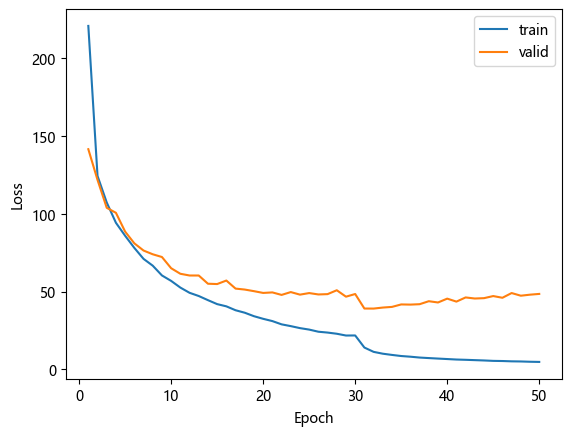

In [10]:
train_loss = history.history['loss']
valid_loss = history.history['val_loss']
plt.plot(np.linspace(1, epochs, epochs), train_loss, label='train')
plt.plot(np.linspace(1, epochs, epochs), valid_loss, label='valid')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [18]:
sub_model.save('sub_asr_1.h5')

with open('dictionary.pkl', 'wb') as fw:
    pickle.dump([char2id, id2char, mfcc_mean, mfcc_std], fw)

In [97]:
from tensorflow.keras.models import load_model
import pickle

with open('dictionary.pkl', 'rb') as fr:
    [char2id, id2char, mfcc_mean, mfcc_std] = pickle.load(fr)

sub_model = load_model('sub_asr_1.h5')

def random_predict(x, y):
    index = np.random.randint(len(x))
    feature = x[index]
    text = y[index]
    
    pred = sub_model.predict(np.expand_dims(feature, axis=0))
    pred_ids = K.eval(K.ctc_decode(pred, [feature.shape[0]], greedy=False, beam_width=10, top_paths=1)[0][0])
    pred_ids = pred_ids.flatten().tolist()
    
    print('True transcription:\n-- ', text, '\n')
    # 防止音频中出现字典中不存在的字，返回空格代替
    print('Predicted transcription:\n--  ' + ''.join([id2char.get(i, ' ') for i in pred_ids]), '\n')


random_predict(X_train, Y_train)
random_predict(X_test, Y_test)

1/1 [==============================] - 2s 2s/step
True transcription:
--  当我病愈去医院看望您时您这个年长者却躺在病床上紧紧拉着我的手殷殷嘱我保重 

Predicted transcription:
--  当我病愈去医院看望您时您这个年长者却躺在病床上紧拉着我的手殷嘱我保重                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

1/1 [==============================] - 2s 2s/step
True transcrip

In [95]:
import pyaudio
import wave

def record_audio(output_wav_path, duration=5, sample_rate=44100, chunk_size=1024):
    audio = pyaudio.PyAudio()

    # 打开麦克风
    stream = audio.open(format=pyaudio.paInt16,
                        channels=1,
                        rate=sample_rate,
                        input=True,
                        frames_per_buffer=chunk_size)

    print("Recording...")

    frames = []

    # 监听并录制音频
    for _ in range(0, int(sample_rate / chunk_size * duration)):
        data = stream.read(chunk_size)
        frames.append(data)

    print("Recording finished.")

    # 关闭麦克风
    stream.stop_stream()
    stream.close()
    audio.terminate()

    # 保存录制的音频为 WAV 文件
    with wave.open(output_wav_path, 'wb') as wf:
        wf.setnchannels(1)
        wf.setsampwidth(audio.get_sample_size(pyaudio.paInt16))
        wf.setframerate(sample_rate)
        wf.writeframes(b''.join(frames))

        
output_wav_path = "recorded_audio.wav"
record_audio(output_wav_path, duration=5)


Recording...
Recording finished.


In [96]:
import librosa

def single_predict(audio_path):
    # 加载和修剪音频
    audio, sr = load_and_trim(audio_path)
    
    # 计算音频的MFCC特征
    feature = mfcc(audio, sr, numcep=mfcc_dim, nfft=551)
    
    feature = (feature - mfcc_mean) / (mfcc_std + 1e-14)
    
    pred = sub_model.predict(np.expand_dims(feature, axis=0))
    pred_ids = K.eval(K.ctc_decode(pred, [feature.shape[0]], greedy=False, beam_width=10, top_paths=1)[0][0])
    pred_ids = pred_ids.flatten().tolist()
    
    print('Predicted transcription:\n--  ' + ''.join([id2char.get(i, ' ') for i in pred_ids]), '\n')

# Specify the path to your MP3 audio file
audio_path = "recorded_audio.wav"

single_predict(audio_path)

1/1 [==============================] - 0s 207ms/step
Predicted transcription:
--  在吹季中或像湿应特称副食道文斯和碰                                                                                                                                                                                                                                                                                                                                                                                                                                                          

